# Template Matching

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2

from helpers import imshow

## Simple Template Matching
In this section, we will apply template matching to the frame of a video game in order to detect the location of the player on the map.
### Load sources

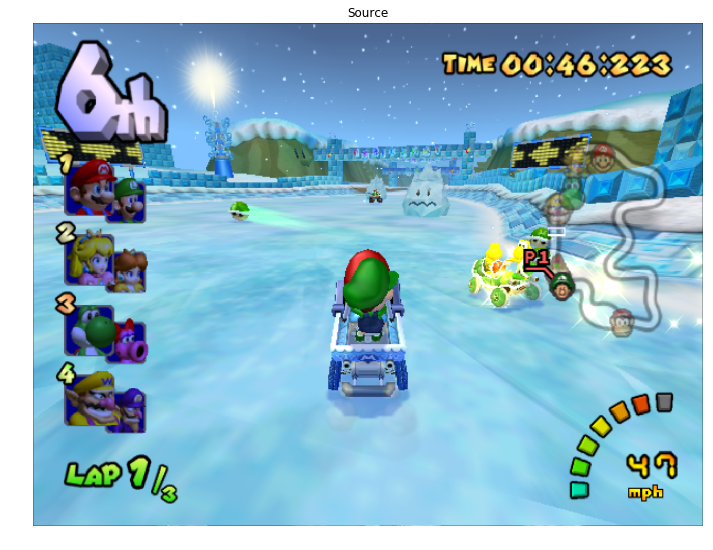

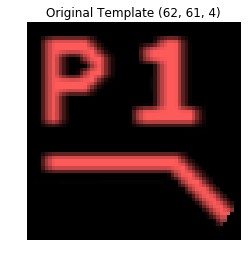

In [2]:
im = cv2.imread('img/sherbet_land.png')
tm = cv2.imread('img/p1.png', cv2.IMREAD_UNCHANGED) # reads alpha channel

plt.figure(figsize=(12,12))
imshow(im, 'Source')
imshow(tm, 'Original Template {}'.format(tm.shape))


### Add noise to compensate for alpha
Because OpenCV doesn't support template masks in `cv2.matchTemplate`, we replace the alpha channel in our template with noise. During template matching, the noisy layer will be statistically insignificant compared to the rest of the template - this creates a pseudo-alpha channel for template matching purposes.

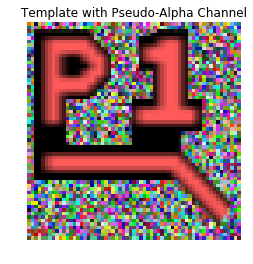

In [3]:
def alpha_to_noise(img):
    '''
    Converts an RGBA image to an RGB image 
    where the alpha channel is replaced with random noise
    '''
    
    l = img.shape[0]
    w = img.shape[1]
    
    img_noise = np.zeros((l,w,3), np.uint8)
    
    for i in range(l):
        for j in range(w):
            pixel = img[i,j]
            rgb   = pixel[:3]
            alpha = pixel[3]/255
            
            img_noise[i,j] = alpha*rgb + (1-alpha)*np.random.rand(3)*255 
        
    return img_noise
    
if tm is not None and tm.shape[2] > 3:
    tm = alpha_to_noise(tm)
    imshow(tm, 'Template with Pseudo-Alpha Channel')


### Template matching with all  the matching functions
Perform template matching with all of the known template matching difference/similarity functions. The square difference functions are (as implied in their name) difference functions, the minimum value in the result image in is the best-matched template. The other functions are similarity functions, so the best match will be a maximum in the result image.

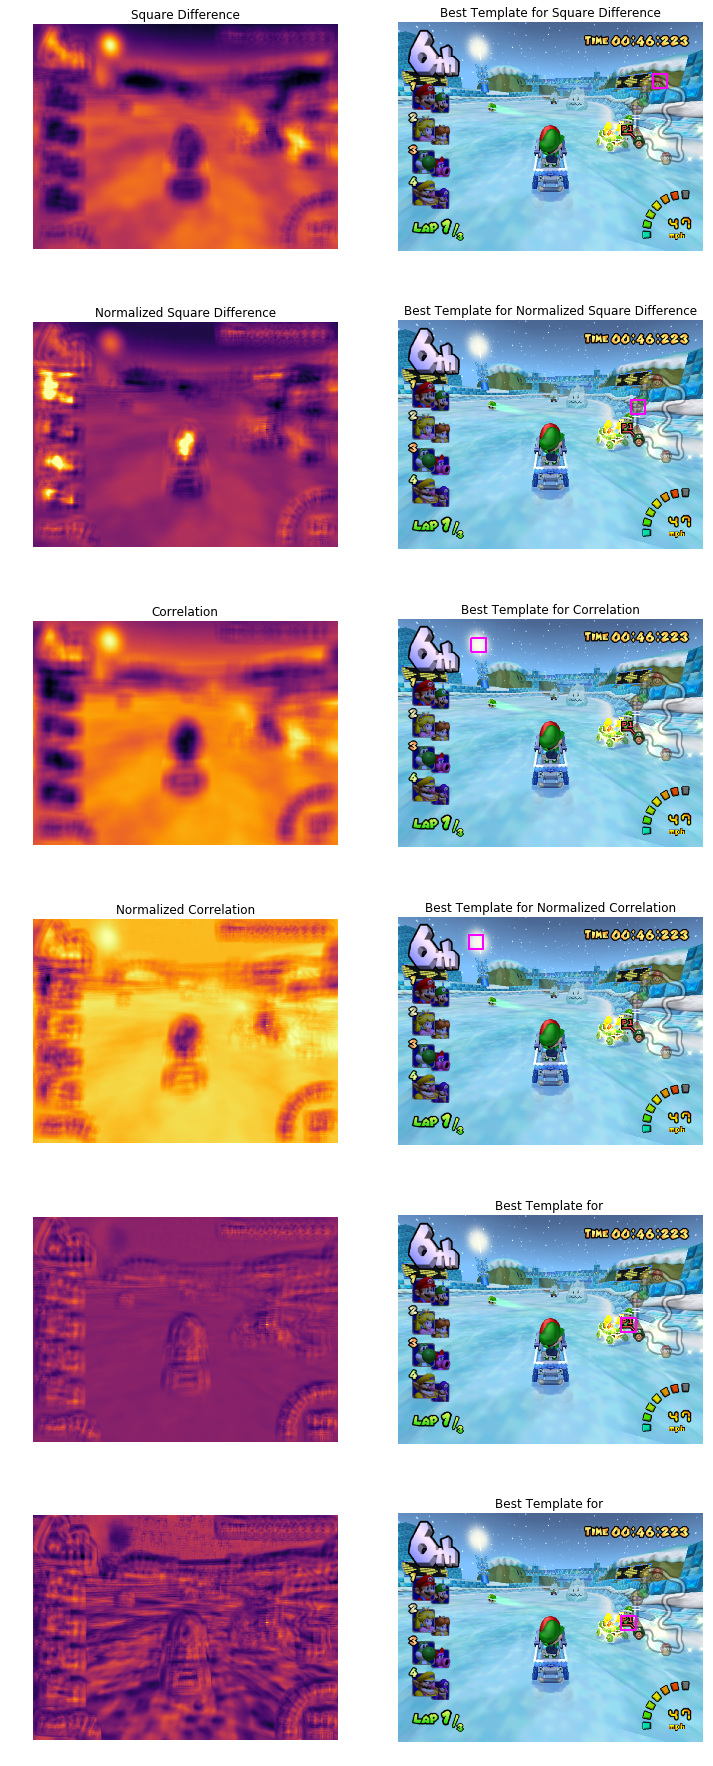

In [4]:
plt.figure(figsize=(12,32))

tm_functions = [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED,
                cv2.TM_CCORR,  cv2.TM_CCORR_NORMED,
                cv2.TM_CCOEFF, cv2.TM_CCOEFF_NORMED]

tm_names     = ['Square Difference', 'Normalized Square Difference',
                'Correlation','Normalized Correlation','','']

for i, (tm_function, tm_name) in enumerate(zip(tm_functions, tm_names)):
    
    # Perform and display template matching
    match = cv2.matchTemplate(im, tm, tm_function)
    plt.subplot(6,2, 1 + i*2)
    plt.imshow(match, cmap='inferno')
    plt.title(tm_name)
    plt.axis('off')
    
    # Find the location of the strongest match
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(match)
    if tm_function == cv2.TM_SQDIFF or tm_function == cv2.TM_SQDIFF_NORMED:
        match_loc = min_loc
    else:
        match_loc = max_loc
    
    # Draw a rectangle around the strongest match
    p0 = match_loc
    p1 = (match_loc[0] + tm.shape[0], match_loc[1] + tm.shape[1])
    im_square = im.copy()
    cv2.rectangle(im_square, p0, p1, (255,0,255), 8)
    
    # Display image with detected template
    plt.subplot(6, 2, 2 + i*2)
    plt.imshow(cv2.cvtColor(im_square, cv2.COLOR_BGR2RGB))
    plt.title('Best Template for {}'.format(tm_name))
    plt.axis('off')
    

## Multiple Template Matching
To find multiple instances of a template in a single frame, a threshold can be used on the output of the template matcher. Sometimes the threshold will be met for multiple points on the same object. To avoid this, we can first find the local maxima/minima of the template match results, then apply the threshold to these points. We do this in the next section (edge-based template matching).

We are looking for exact matches of our template, which is a cutout of our back button containing no transparent pixels. Note that there is a back button in the "Display" window (top left), which is a 20px rendering of the button and our template is from the 22px rendering of the button, so the "Display" window back button is not detected.

Check [img/screenshot.png](img/screenshot.png) for a larger version of the source image.

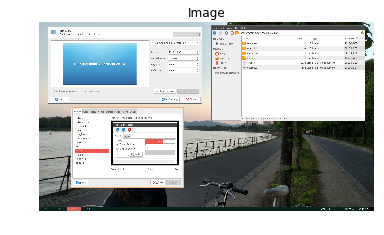

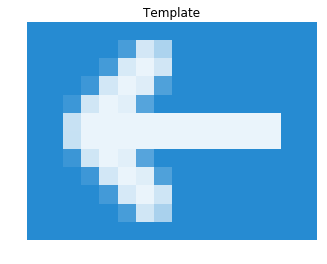

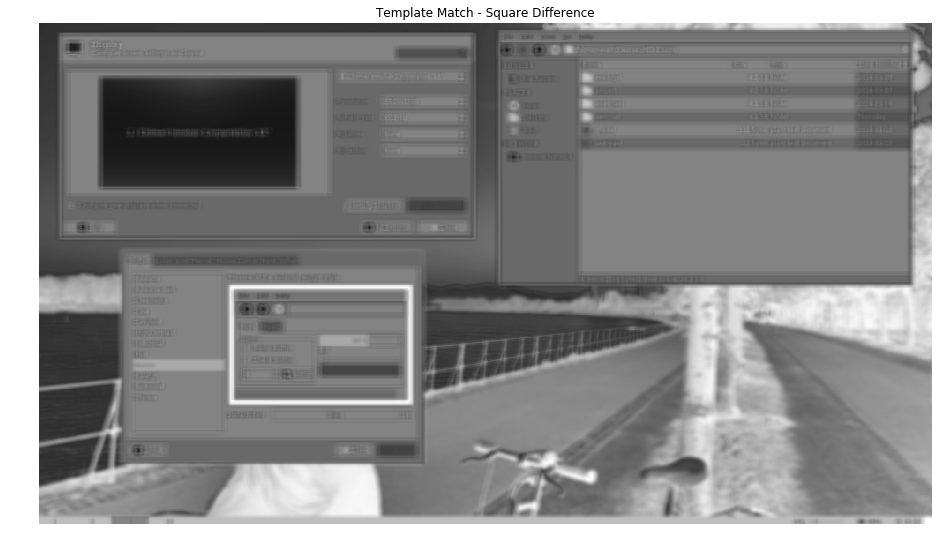

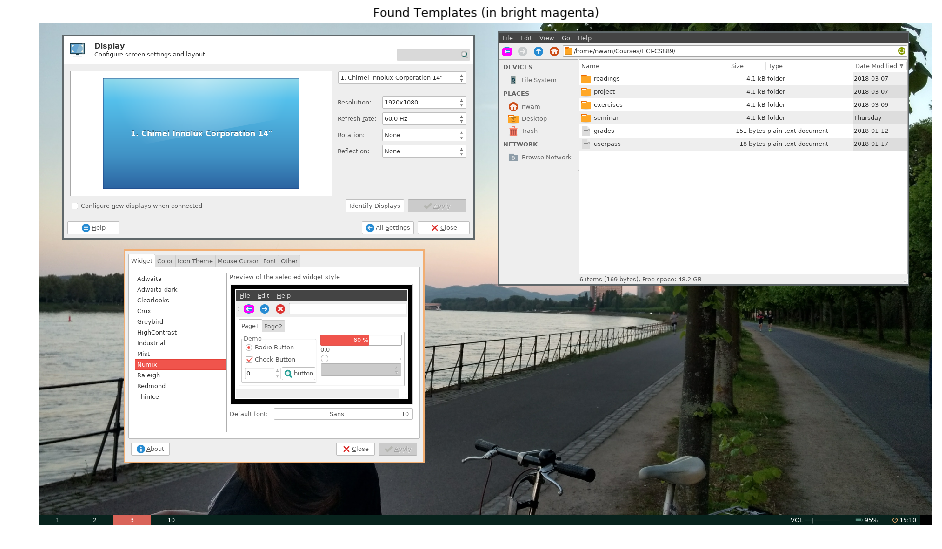

In [67]:
# Some constants
threshold = 0 # exact matches only

# Load sources
im = cv2.imread('img/screenshot.png')
tm = cv2.imread('img/back_button.png')
imshow(im, 'Image')
imshow(tm, 'Template')

# Perform template matching
match = cv2.matchTemplate(im, tm, cv2.TM_SQDIFF)

# Find the location of matched templates
match_locs = np.where(match <= threshold)
match_loc = match_locs[0]

# Draw a rectangle around all of the matches
for match_loc in zip(*match_locs[::-1]):
    p0 = match_loc
    p1 = (match_loc[0] + tm.shape[1], match_loc[1] + tm.shape[0])
    cv2.rectangle(im, p0, p1, (255, 0, 255), 4)

# Show results
plt.figure(figsize=(16,16))
imshow(match, 'Template Match - Square Difference')

plt.figure(figsize=(16,16))
imshow(im, 'Found Templates (in bright magenta)')


## Edge-Based Template Matching
If we are dealing with a natural image, template matching may not be sufficient on its own because of its sensitivity to varying brightnesses. By performing edge detection first, we can eliminate brightness and color variance variance and can even speed up the process (if the image dimentionality is reduced from edge detection).

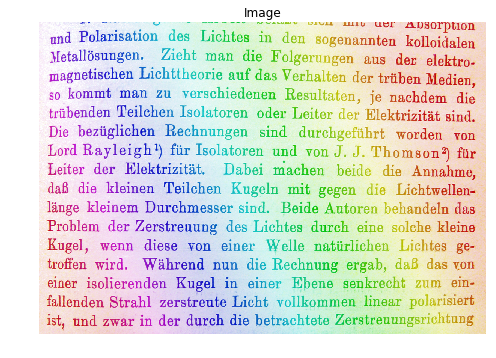

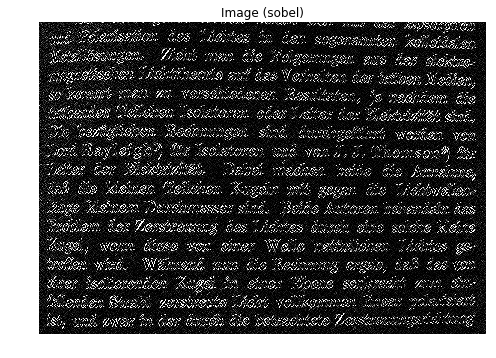

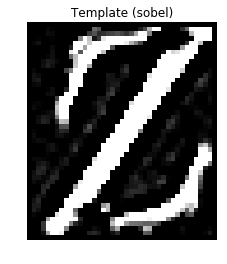

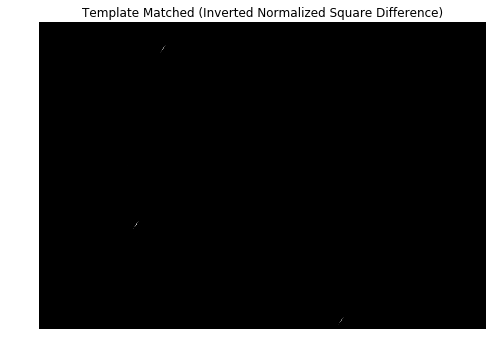

Found matches at [(95, 443), (723, 347), (1066, 1080)]


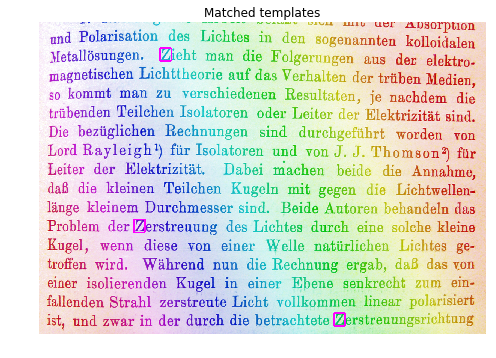

In [22]:
# Load sources
im = cv2.imread('img/german_text_rainbow.png')
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(8,8))
imshow(im, 'Image')

tm = cv2.imread('img/german_text_Z.png')
tm = cv2.cvtColor(tm, cv2.COLOR_BGR2GRAY)

# Detect edges
sobel = cv2.Sobel(gray,cv2.CV_8U,1,1,ksize=5)
plt.figure(figsize=(8,8))
imshow(sobel, 'Image (sobel)')

tm = cv2.Sobel(tm,cv2.CV_8U,1,1,ksize=5)
imshow(tm, 'Template (sobel)')

# Template match
match = cv2.matchTemplate(sobel, tm, cv2.TM_SQDIFF_NORMED)
match = 1 - match
plt.figure(figsize=(8,8))
imshow(match, 'Template Matched (Inverted Normalized Square Difference)')


# Find local maxima above threshold
# There may be other, more efficient ways to do this,
# such as dialating, finding blobs, and checking if the blob's
# max value is greater than the threshold
match_locs = []
thresh = 0.5
tmx = tm.shape[1]
tmy = tm.shape[0]

for i in range(match.shape[0]):
    for j in range(match.shape[1]):
        v = match[i,j]
        if v >= thresh:
            # Make sure v is a maximum among its neighbors
            start_x = max(j-tmx, 0)
            end_x = min(j+tmx, match.shape[1])
            start_y = max(i-tmy, 0)
            end_y = min(i+tmy, match.shape[0])
            if v >= np.max(match[start_y:end_y, start_x:end_x]):
                match[i,j] = match[i,j] + 1 # make sure no equal maxima also get counted
                match_locs.append((j,i))
                
print('Found matches at {}'.format(matches))

# Draw squares on original image
for match_loc in match_locs:
    p0 = match_loc
    p1 = (match_loc[0] + tm.shape[1], match_loc[1] + tm.shape[0])
    cv2.rectangle(im, p0, p1, (255, 0, 255), 4)
    
plt.figure(figsize=(8,8))
imshow(im, 'Matched templates')

## Rotation- and Scale- Invariant Template Matching
Sometimes we may want to find occurances of a template, but the occurances have been rotated or scaled. To do so, we rotate and/or scale the source image, and record the best template matching score and its corresponding rotation and scale among all of the rotated and/or scaled images. We finish by applying the corresponding rotation and/or scale to the rectangle we draw. Note that it is important to use a normalized similarity/difference formula because of the varying scale.

Here is the original [image](img/haribo1.jpg) and [template](img/haribo_logo.png). Note their size differences.

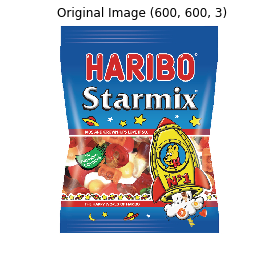

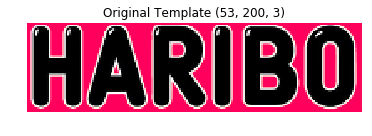

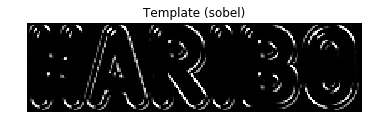

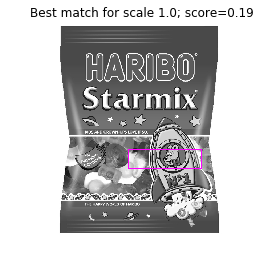

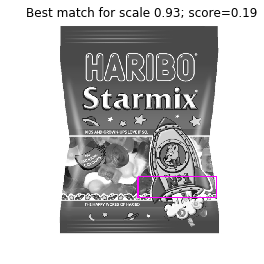

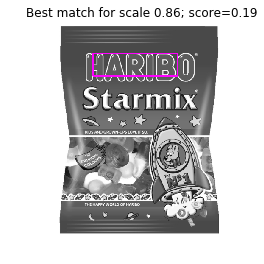

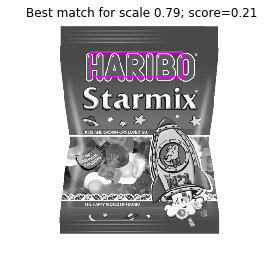

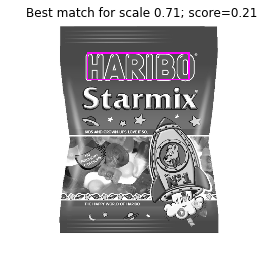

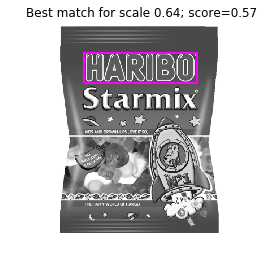

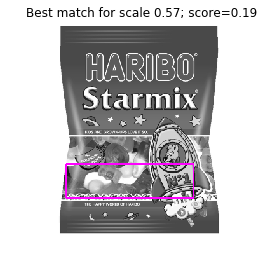

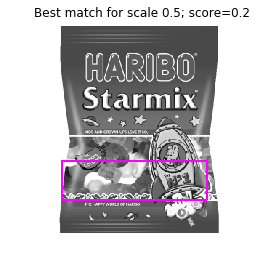

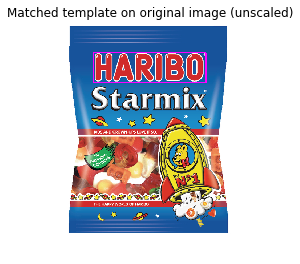

In [65]:
num_sizes = 8
max_scale = 1.0
min_scale = 0.5

# Load sources
im = cv2.imread('img/haribo1.jpg')
tm = cv2.imread('img/haribo_logo.png')

imshow(im, 'Original Image {}'.format(im.shape))
imshow(tm, 'Original Template {}'.format(tm.shape))

# Preprocessing
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
tm = cv2.cvtColor(tm, cv2.COLOR_BGR2GRAY)
tm = cv2.Sobel(tm,cv2.CV_8U,1,1,ksize=3)
imshow(tm, 'Template (sobel)')

# Iterate through different sizes of source image
best_match_loc = None
best_match_size = None
best_match_score = 0
sizes = np.linspace(max_scale, min_scale, num_sizes)

for size in sizes:
    # Resize and match
    resized = cv2.resize(gray, (0,0), fx=size, fy=size)
    sobel = cv2.Sobel(resized,cv2.CV_8U,1,1,ksize=3)
    match = cv2.matchTemplate(sobel, tm, cv2.TM_CCORR_NORMED)
    
    # Find the location of the strongest match
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(match)
    match_loc = max_loc
    match_score = max_val
    
    # Draw a rectangle around the strongest match
    p0 = match_loc
    p1 = (match_loc[0] + tm.shape[1], match_loc[1] + tm.shape[0])
    resized = cv2.cvtColor(resized, cv2.COLOR_GRAY2BGR)
    cv2.rectangle(resized, p0, p1, (255,0,255), 2)
    imshow(resized, 'Best match for scale {:.2}; score={:.2}'.format(size, match_score))

    # Update best match
    if match_score > best_match_score:
        best_match_loc = match_loc
        best_match_size = size
        best_match_score = match_score
        
# Apply the best match to the original image
p0 = tuple(map(lambda x:int(x/best_match_size), best_match_loc))
p1 = (int(p0[0] + tm.shape[1]/best_match_size), int(p0[1] + tm.shape[0]/best_match_size))
cv2.rectangle(im, p0, p1, (255,0,255), 2)
imshow(im, 'Matched template on original image (unscaled)')

## Template matching in an HCI application
In this section, we have created a game where users try their best to draw the template. Whoever draws the best-matching template wins.

In [85]:
import time

# Setup capture
camera = cv2.VideoCapture(0)
camera.set(cv2.CAP_PROP_EXPOSURE, 0.1)

start_time = time.time()
game_time = 60
timer = game_time

# Reduce frame size to speed up processing
# Also lets us know the capture resolution (can't seem to get it through opencv)
w = 640
h = int(w * 3/4)
camera.set(cv2.CAP_PROP_FRAME_WIDTH, w) 
camera.set(cv2.CAP_PROP_FRAME_HEIGHT, h) 

# For frame processing to get clean thresholding
processed = np.ones((h,w))
preprocessed_alpha = 0.25

# Load template
tm_bgr = cv2.imread('game_templates/checkmark.png')
tm = cv2.cvtColor(tm_bgr, cv2.COLOR_BGR2GRAY)
cv2.threshold(tm,127,255,cv2.THRESH_BINARY)

tm_h = tm.shape[0]
tm_w = tm.shape[1]
tm_hs = int(h/2-tm_h/2) # template height start
tm_he = int(h/2+tm_h/2) # template height end
tm_ws = int(w/2-tm_w/2) # template width start
tm_we = int(w/2+tm_w/2) # template width end

# Drawing parameters
GRID_LINES = 3
p_color = [(0,0,255), (255,0,0)]
p_name = ["Player 0", "Player 1"]
p_score = np.array([0,0])

# capture loop
while True:
    
    # Get remaining time
    timer = int(game_time + start_time - time.time() + 1)
    
    # Get keyboard input
    key = cv2.waitKey(5)
    
    # Get frame
    ret, frame = camera.read()

    # Mirror the frame
    frame = cv2.flip(frame, 1)
    
    # Process frame for clean thresholding
    preprocessed = cv2.GaussianBlur(frame, (9,9), 0)
    preprocessed = cv2.cvtColor(preprocessed, cv2.COLOR_BGR2GRAY)
    preprocessed = cv2.adaptiveThreshold(preprocessed, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    processed = ((1-preprocessed_alpha)*processed + preprocessed_alpha*preprocessed).astype(np.uint8)
    
    # Get scores of each player
    match = cv2.matchTemplate(processed, tm, cv2.TM_SQDIFF_NORMED)
    match = 1 - match
    _, p0_max_val, _, p0_max_loc = cv2.minMaxLoc(match[:,:int(w/2)-tm_w])
    _, p1_max_val, _, p1_max_loc = cv2.minMaxLoc(match[:,int(w/2):])
    p_score[0] = int(p0_max_val*100)
    p_score[1] = int(p1_max_val*100)
    p0_match_loc = p0_max_loc
    p1_match_loc = (p1_max_loc[0]+int(w/2), p1_max_loc[1])
    
    # Draw info on frame
    frame [:,int(w/2)] = (0,255,0) # divider
    frame [tm_hs:tm_he, tm_ws:tm_we] = tm_bgr # template
    
    for row in np.linspace(tm_hs, tm_he, GRID_LINES).astype(int):
        frame[row,tm_ws:tm_we] = (255,0,255) # template horizontal grids
    for col in np.linspace(tm_ws, tm_we, GRID_LINES).astype(int):
        frame[tm_hs:tm_he,col] = (255,0,255) # template vertical grids
        
    cv2.rectangle(frame, p0_match_loc, (p0_match_loc[0]+tm_h, p0_match_loc[1]+tm_w), p_color[0], 3) # player 0 match
    cv2.rectangle(frame, p1_match_loc, (p1_match_loc[0]+tm_h, p1_match_loc[1]+tm_w), p_color[1], 3) # player 1 match  
    
    cv2.putText(frame, str(p_score[0]), (int(w/4)-20, 30),  cv2.FONT_HERSHEY_DUPLEX, 1, p_color[0])
    cv2.putText(frame, str(p_score[1]), (int(w*3/4), 30),  cv2.FONT_HERSHEY_DUPLEX, 1, p_color[1])
    
    if timer > 0:
        cv2.putText(frame, str(timer), (int(w/2)-20, 30), cv2.FONT_HERSHEY_DUPLEX, 1, (255,0,255))
    else:
        # Show winner text
        win_player = np.argmax(p_score)
        win_color = p_color[win_player]
        win_text = '{} wins!!'.format(p_name[win_player])
        if p_score[0] == p_score[1]:
            win_color = (0,255,255)
            win_text = 'Everyone is a winner!!'
    
        cv2.putText(frame, win_text, (int(w/2)-8*len(win_text), 160), cv2.FONT_HERSHEY_DUPLEX, 1, win_color, thickness = 3)
        
        # Show win screen until user quits
        while True:
            cv2.imshow('frame', frame)
            key = cv2.waitKey(5)
            if key == ord('q'):
                break

    # Show frame
    cv2.imshow('match', match)
    cv2.imshow('frame', frame)
    cv2.imshow('processed', processed)
    
    # Keyboard actions    
    if key == ord('q'):
        break
        

        
# Clean up
cv2.destroyAllWindows()
camera.release()
cv2.waitKey(1) # extra waitKey sometimes needed to close camera window

-1